In [1]:
import numpy as np
import config as g
import matplotlib.pyplot as plt
from numba import jit
import matplotlib

np.random.seed(0)

matplotlib.rcParams["figure.figsize"] = [20,45]
matplotlib.rcParams.update({'font.size': 20})

In [2]:
@jit
def remesh(points, x, y, strengths):

    vorticity_distr = np.zeros_like(x)
    for point,strength in zip(points.T,strengths):
        i, j = ((point - np.array([g.x1,g.y1]))/g.h).astype(int)
        vorticity_distr[i-1,j-1]    += (g.h - (point[0] - x[i,j]))*(g.h-(point[1]-y[i,j]))*strength
        vorticity_distr[i,j-1]      += (point[0] - x[i,j])*(g.h-(point[1]-y[i,j]))*strength
        vorticity_distr[i-1,j]      += (g.h - (point[0] - x[i,j]))*(point[1]-y[i,j])*strength
        vorticity_distr[i,j]        += (point[0] - x[i,j])*(point[1]-y[i,j])*strength
    
    return vorticity_distr/(g.h**2)


def main(x,y,numPoints = g.N):


    points    = np.zeros((2,numPoints))
    strengths = np.zeros((numPoints)) + g.strength/numPoints
    
    displacements = np.random.normal(0.0,np.sqrt(2*g.nu*g.T),(2,numPoints))
    points = points + displacements

    rsq = x**2 + y**2
    remeshed = remesh(points,x,y,strengths)
    actual = np.exp(-1*rsq/(4*g.nu*g.T))/(4*np.pi*g.nu*g.T)
    return points,remeshed,actual


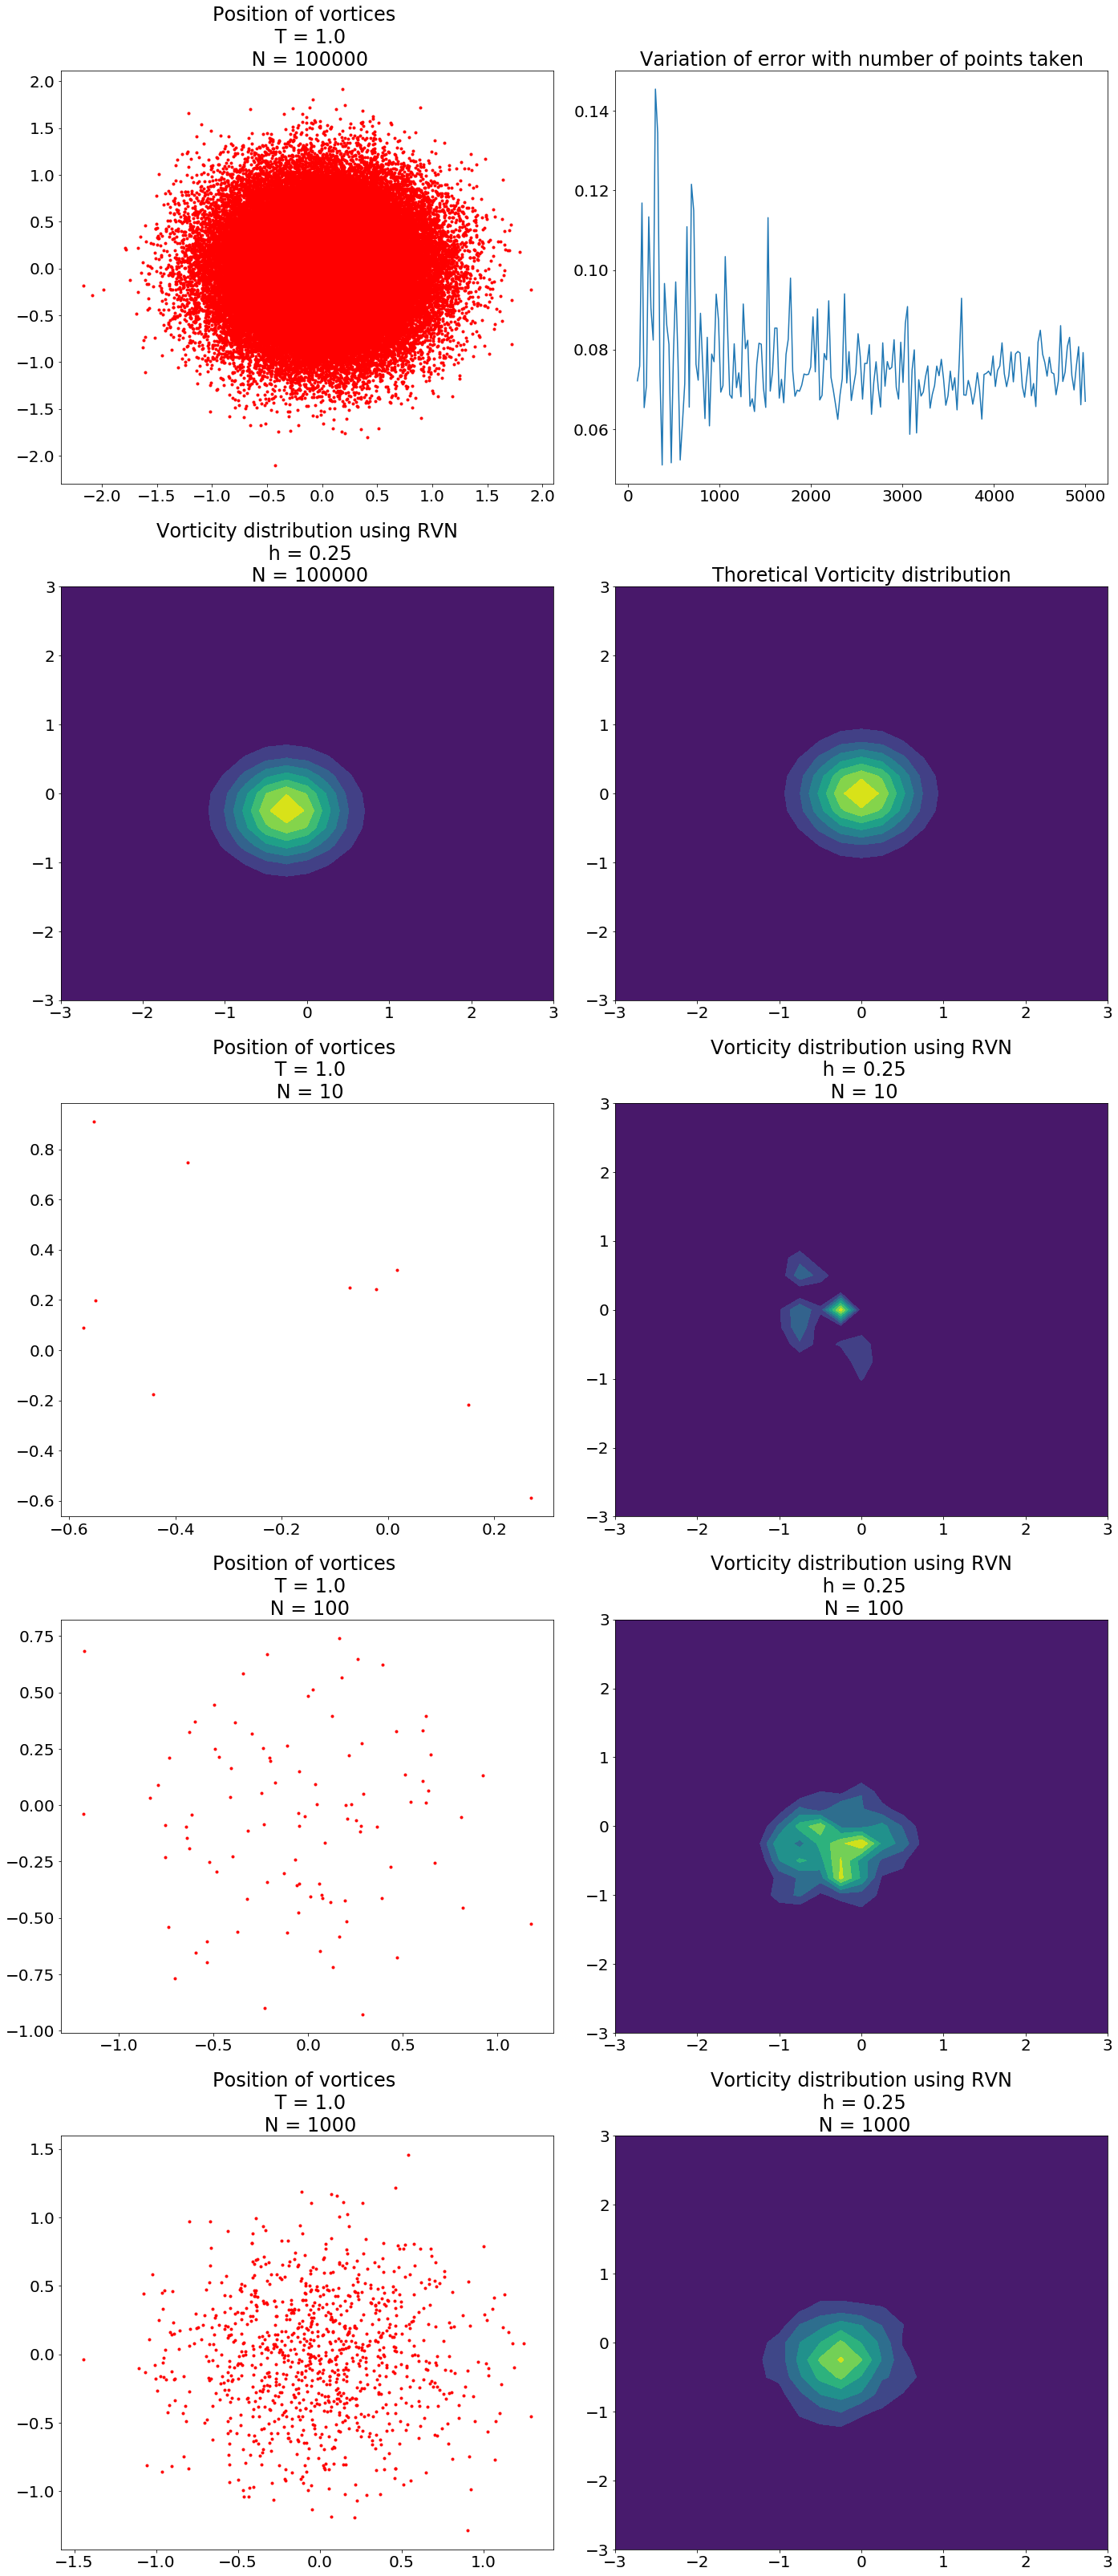

In [3]:
gridnum         = int((g.x2-g.x1)/g.h) + 1
x,y = np.mgrid[g.x1:g.x2:gridnum*1j, g.y1:g.y2:gridnum*1j]

points,remeshed,actual = main(x,y)

fig,ax = plt.subplots(5,2)

plt_points, = ax[0,0].plot(points[0,:], points[1,:], 'r.')
ax[0,0].set_title("Position of vortices \n T = " + str(g.T) +"\n N = " + str(g.N))

plt_sim = ax[1,0].contourf(x,y,remeshed)
ax[1,0].set_title("Vorticity distribution using RVN\n h = " + str(g.h) +"\n N = "+ str(g.N))

plt_actual = ax[1,1].contourf(x,y,actual)
ax[1,1].set_title("Thoretical Vorticity distribution")

for i,n in enumerate([10,100,1000]):
    points,remeshed,actual = main(x,y, n)

    plt_points, = ax[2+i,0].plot(points[0,:], points[1,:], 'r.')
    ax[2+i,0].set_title("Position of vortices \n T = " + str(g.T) +"\n N = " + str(n))

    plt_sim = ax[2+i,1].contourf(x,y,remeshed)
    ax[2+i,1].set_title("Vorticity distribution using RVN\n h = " + str(g.h) +"\n N = "+ str(n))

errors = []
numpoints_all = np.ceil(np.linspace(100,5000,200)).astype(int)
for numpoints in numpoints_all:
    _,remeshed,actual = main(x,y,numPoints=numpoints)
    remeshed = remeshed*actual[12,12]/remeshed[12,12]
    errors.append(np.sqrt(np.mean((actual-remeshed)**2)))

ax[0,1].plot(numpoints_all,errors)
ax[0,1].set_title("Variation of error with number of points taken")
plt.tight_layout()
plt.show()